<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=170 style="padding: 10px"> 
<b>Little Demo: Point source color-magnitude and color-color diagrams</b> <br>
Contact author(s): Jeff Carlin and Yumi Choi <br>
Last verified to run: 2024-01-28 <br>
LSST Science Pipelines version: Weekly 2023_47 <br>
Container Size: small

Create point source color-magnitude (CMD) and color-color diagram(s).

Section 5 describest how to create the same figures in the Portal. <br>

## 1. Set up

Import packages.

In [1]:
import matplotlib.pyplot as plt
from lsst.rsp import get_tap_service, retrieve_query

Instantiate the TAP service.

In [2]:
service = get_tap_service("tap")

Explore the DP0.2 schema.

In [3]:
dp02_schema_name = 'dp02_dc2_catalogs'

In [18]:
query = "SELECT * FROM tap_schema.tables " \
        "WHERE tap_schema.tables.schema_name = '" \
        + dp02_schema_name + "' order by table_index ASC"

results = service.search(query).to_table()
results

description,schema_name,table_index,table_name,table_type,utype
str512,str512,int32,str64,str8,str512
Properties of the astronomical objects detected and measured on the deep coadded images.,dp02_dc2_catalogs,1,dp02_dc2_catalogs.Object,table,
"Properties of detections on the single-epoch visit images, performed independently of the Object detections on coadded images.",dp02_dc2_catalogs,2,dp02_dc2_catalogs.Source,table,
"Forced-photometry measurements on individual single-epoch visit images and difference images, based on and linked to the entries in the Object table. Point-source PSF photometry is performed, based on coordinates from a reference band chosen for each Object and reported in the Object.refBand column.",dp02_dc2_catalogs,3,dp02_dc2_catalogs.ForcedSource,table,
Properties of time-varying astronomical objects based on association of data from one or more spatially-related DiaSource detections on individual single-epoch difference images.,dp02_dc2_catalogs,4,dp02_dc2_catalogs.DiaObject,table,
Properties of transient-object detections on the single-epoch difference images.,dp02_dc2_catalogs,5,dp02_dc2_catalogs.DiaSource,table,
"Point-source forced-photometry measurements on individual single-epoch visit images and difference images, based on and linked to the entries in the DiaObject table.",dp02_dc2_catalogs,6,dp02_dc2_catalogs.ForcedSourceOnDiaObject,table,
"Metadata about the pointings of the DC2 simulated survey, largely associated with the boresight of the entire focal plane.",dp02_dc2_catalogs,7,dp02_dc2_catalogs.Visit,table,
Metadata about the 189 individual CCD images for each Visit in the DC2 simulated survey.,dp02_dc2_catalogs,8,dp02_dc2_catalogs.CcdVisit,table,
Static information about the subset of tracts and patches from the standard LSST skymap that apply to coadds in these catalogs,dp02_dc2_catalogs,9,dp02_dc2_catalogs.CoaddPatches,table,


Get the columns available for the dp02_dc2_catalogs.Object table.

In [25]:
results = service.search("SELECT column_name, datatype, description, unit from TAP_SCHEMA.columns "
                         "WHERE table_name = 'dp02_dc2_catalogs.Object'")
results.to_table().to_pandas()

,column_name,datatype,description,unit
0,coord_dec,double,Fiducial ICRS Declination of centroid used for...,deg
1,coord_ra,double,Fiducial ICRS Right Ascension of centroid used...,deg
2,deblend_nChild,int,Number of children this object has (defaults t...,
3,deblend_skipped,boolean,Deblender skipped this source,
4,detect_fromBlend,boolean,This source is deblended from a parent with mo...,
...,...,...,...,...
986,z_psfFlux_flag_apCorr,boolean,Set if unable to aperture correct base_PsfFlux...,
987,z_psfFlux_flag_edge,boolean,Object was too close to the edge of the image ...,
988,z_psfFlux_flag_noGoodPixels,boolean,Not enough non-rejected pixels in data to atte...,
989,z_psfFluxErr,double,Flux uncertainty derived from linear least-squ...,nJy


Clean up

In [7]:
del results

## 2. TAP query

Define the TAP query to retrieve point-like Objects in a 2-degree radius region. The Object catalog contains objects detected in deep coadds.

In [43]:
query = """
SELECT 
    scisql_nanojanskyToAbMag(g_psfFlux) as gmag, 
    scisql_nanojanskyToAbMag(r_psfFlux) as rmag, 
    scisql_nanojanskyToAbMag(i_psfFlux) as imag,
    scisql_nanojanskyToAbMag(z_psfFlux) as zmag,
    scisql_nanojanskyToAbMag(y_psfFlux) as ymag
FROM 
    dp02_dc2_catalogs.Object 
WHERE 
    CONTAINS(POINT('ICRS', coord_ra, coord_dec), 
    CIRCLE('ICRS', 55.75, -32.27, 2.0)) = 1 
    AND detect_isPrimary = 1 
    AND i_extendedness = 0 AND z_extendedness = 0 
    AND i_psfFlux/i_psfFluxErr > 5 
    AND z_psfFlux/z_psfFluxErr > 5 
    AND y_psfFlux/y_psfFluxErr > 5 
"""

Execute the query, and store the results in an `astropy` table.

In [44]:
results = service.search(query).to_table()

Uncomment the following cell to view the table.

In [45]:
results

gmag,rmag,imag,zmag,ymag
float64,float64,float64,float64,float64
26.67305517131549,25.89302538988143,25.015782260025034,24.500732031450983,24.274383493143233
23.076937760466407,22.863000105403856,22.780446998929875,22.78936777606165,22.67358707207974
26.630587548000502,25.797515462278817,24.32867748748572,23.62313268853122,23.339057902924047
27.01902234385811,25.92432105678553,24.968414075834286,24.167521010574465,23.401452343595786
25.2640981944904,24.085663742962147,22.85086984498647,22.318614895720795,22.041844419930868
20.48418928976165,20.034239041902346,19.84916238517401,19.778910012320203,19.743229622379925
20.810545920144662,20.51523188796228,20.408176156083766,20.3720820061876,20.38280944522984
26.326459913949495,25.70901310111031,24.961206915308487,24.34608889673433,23.863170696305335
22.60245758599457,21.448154131474965,20.213049234090892,19.684214759565243,19.451712947820386


## 3. Create CMDs and color-color diagrams

Plot i-band magnitude vs. g-r color, then i-z color, as scatter plots.

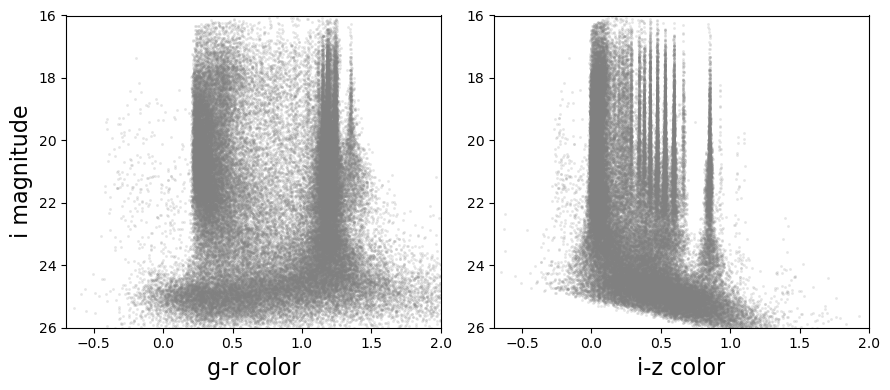

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

ax[0].plot(results['gmag'] - results['rmag'], results['imag'], 
           'o', ms=2, color='gray', alpha=0.2, mew=0)
ax[0].set_xlabel('g-r color', fontsize=16)
ax[0].set_ylabel('i magnitude', fontsize=16)
ax[0].set_xlim(-0.7, 2)
ax[0].set_ylim(26, 16)

ax[1].plot(results['imag'] - results['zmag'], results['imag'],
           'o', ms=2, color='grey', alpha=0.2, mew=0)
ax[1].set_xlabel('i-z color', fontsize=16)
ax[1].set_xlim(-0.7, 2)
ax[1].set_ylim(26, 16)

plt.tight_layout()
plt.show()

Plot color-color diagrams for (r-i) vs. (g-r), (r-z) vs. (g-r), and (z-y) vs. (i-z).

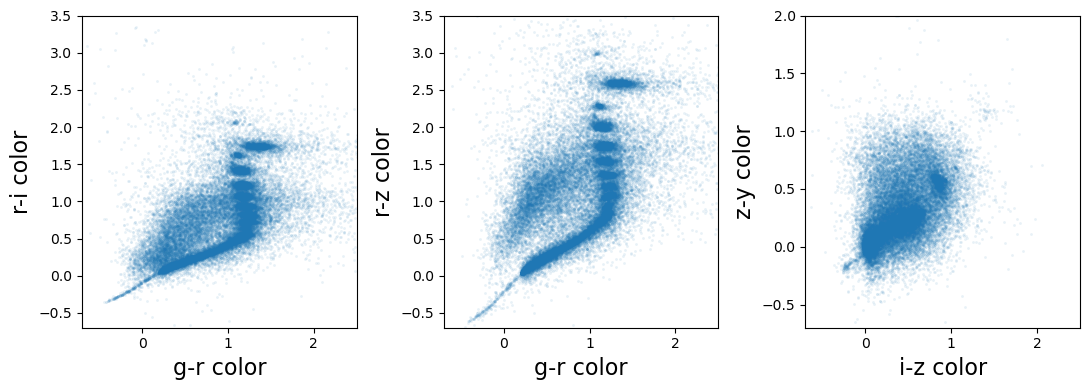

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(11, 4))

ax[0].plot(results['gmag'] - results['rmag'], results['rmag'] - results['imag'],
           'o', ms=2, alpha=0.1, mew=0)
ax[0].set_xlabel('g-r color', fontsize=16)
ax[0].set_ylabel('r-i color', fontsize=16)
ax[0].set_ylim(-0.7, 3.5)
ax[0].set_xlim(-0.7, 2.5)

ax[1].plot(results['gmag'] - results['rmag'], results['rmag'] - results['zmag'],
           'o', ms=2, alpha=0.1, mew=0)
ax[1].set_xlabel('g-r color', fontsize=16)
ax[1].set_ylabel('r-z color', fontsize=16)
ax[1].set_ylim(-0.7, 3.5)
ax[1].set_xlim(-0.7, 2.5)

ax[2].plot(results['imag'] - results['zmag'], results['zmag'] - results['ymag'],
         'o', ms=2, alpha=0.1, mew=0)
ax[2].set_xlabel('i-z color', fontsize=16)
ax[2].set_ylabel('z-y color', fontsize=16)
ax[2].set_ylim(-0.7, 2.0)
ax[2].set_xlim(-0.7, 2.5)

plt.tight_layout()
plt.show()

## 4. Examine red point sources (likely cool dwarfs)

### Select candidate MLT dwarfs

Try a color-color selection to isolate the coolest (late-M, L, and T) dwarfs.

In [50]:
cooldwarfs = (results['imag']-results['zmag'] > 1.0) & (results['zmag']-results['ymag'] > 0.6)

Highlight the selected objects in the CMDs.

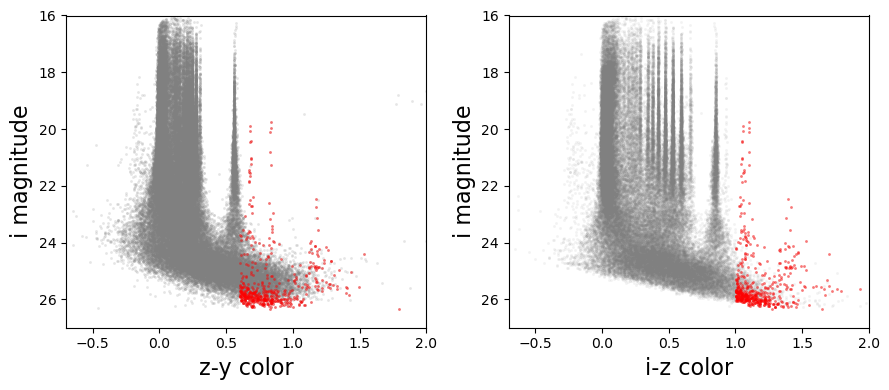

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

ax[0].plot(results['zmag'] - results['ymag'], results['imag'],
           'o', ms=2, color='grey', alpha=0.2, mew=0)
ax[0].plot(results[cooldwarfs]['zmag'] - results[cooldwarfs]['ymag'], 
           results[cooldwarfs]['imag'],
           'o', ms=2, color='red', alpha=0.5, mew=0)
ax[0].set_xlabel('z-y color', fontsize=16)
ax[0].set_ylabel('i magnitude', fontsize=16)
ax[0].set_xlim(-0.7, 2)
ax[0].set_ylim(27, 16)

ax[1].plot(results['imag'] - results['zmag'], results['imag'],
         'o', ms=2, color='grey', alpha=0.1, mew=0)
ax[1].plot(results[cooldwarfs]['imag'] - results[cooldwarfs]['zmag'],
           results[cooldwarfs]['imag'],
           'o', ms=2, color='red', alpha=0.5, mew=0)
ax[1].set_xlabel('i-z color', fontsize=16)
ax[1].set_ylabel('i magnitude', fontsize=16)
ax[1].set_xlim(-0.7, 2)
ax[1].set_ylim(27, 16)

plt.tight_layout()
plt.show()

## 5. Repeat in the Portal

**Option** to execute the same query in the Portal.

5.1. Log in to <a href="https://data.lsst.cloud/">data.lsst.cloud</a> in a new browser tab, and enter the Portal aspect.

5.2. In the Portal, next to “View” at the upper right, switch from the default “UI assisted” to “Edit ADQL”.

5.3. Copy and paste the following into the "ADQL Query" box.
```
SELECT scisql_nanojanskyToAbMag(g_psfFlux) as gmag,
scisql_nanojanskyToAbMag(r_psfFlux) as rmag,
scisql_nanojanskyToAbMag(i_psfFlux) as imag,
scisql_nanojanskyToAbMag(z_psfFlux) as zmag,
scisql_nanojanskyToAbMag(y_psfFlux) as ymag
FROM dp02_dc2_catalogs.Object
WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),
               CIRCLE('ICRS', 55.75, -32.27, 2.0)) = 1
AND detect_isPrimary = 1
AND i_extendedness = 0 AND z_extendedness = 0
AND i_psfFlux/i_psfFluxErr > 5
AND z_psfFlux/z_psfFluxErr > 5
AND y_psfFlux/y_psfFluxErr > 5
```

5.4. At lower left, change the Row Limit to 75000 from the default 50000 and then click "Search".
The Portal will transfer to the results view, which has two components (xy plot and table).

5.5. View the default xy plot, a heatmap (2-d histogram) of g-band magnitude vs. r-band magnitude (i.e., the first two columns of data returned).

5.6. Alter the default xy plot to be a CMD. Click on the double-gears icon at upper right on the "Active Chart" component to open the "Plot Parameters" pop-up window.

5.7. Change "X:" to "imag-zmag" and "Y:" to "imag", check the "reverse" box within "Chart Options" for the y-axis, click "Apply", and then click "Close". The Portal does not currently offer the capability to log scale the heatmap bin values.


<img src="figures/ucd-cmd-portal-screenshot.png" alt="Portal screenshot with final CMD." class="bg-primary" width="500px">